In [5]:
import importlib
import warnings
import datetime
import time
import warnings
import os

import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

import common_func as cf
importlib.reload(cf)
warnings.filterwarnings('ignore')

In [6]:
def select_closest_dn_option(df, delta: float):
    print("Start grouping")
    t = time.process_time()
    # df2 = df.apply(lambda x: x.groupby('Days').apply(lambda g: g.iloc[(g['Delta'] + delta).abs().argsort()[begin:best]]))
        #.groupby('DataDate')
    df2 = df.groupby(['DataDate', 'Days']).apply(lambda g: g.iloc[(g['Delta'] + delta).abs().argsort()[:1]])

    elapsed_time = time.process_time() - t
    print(f"Grouping processed in {elapsed_time} seconds")
    return df2
    #target[0] = df2
    #df2.to_csv(f"grouped/{self.__asset_name}_{option_type}_0.csv")

In [7]:
def load(asset_name: str, folder: str = ""):
    print(f"Start loading {asset_name}")
    t = time.process_time()
    data = pd.read_csv(f'{folder}{asset_name}.csv', sep=",").filter(['UnderlyingPrice', 'Type', 'Expiration',
                                                                'DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume',
                                                                'OpenInterest', 'IV', 'Delta', 'Gamma',
                                                                'Theta', 'Vega'])
    data['Expiration'] = pd.to_datetime(data['Expiration'])
    data['DataDate'] = pd.to_datetime(data['DataDate'])
    data['Days'] = (data['Expiration'] - data['DataDate']).astype('timedelta64[D]').astype(int)
    df_call = data.loc[data['Type'] == "call"]
    df_put = data.loc[data['Type'] == "put"]
    elapsed_time = time.process_time() - t
    print(f"End loading in {elapsed_time} seconds")
    return df_call, df_put

In [8]:
#european_assets = ['BKX', 'DJX', 'HGX', 'MNX', 'MXEA', 'MXEF', 'NDX', 'OSX', 'RLG', 'RLV', 'RUI', 'RUT', 'SIXB', 'SIXC', 'SIXE', 'SIXI', 'SIXM','SIXR', 'SIXRE', 'SIXT', 'SIXU', 'SIXV', 'SIXY', 'SPX', 'SPXPM', 'UTY', 'VIX', 'XDA', 'XDB', 'XDC', 'XDZ', 'XEO']
european_assets = ['NDX', 'RUT', 'SPX']
df_asset = {}
for asset_name in european_assets:
    df_asset[asset_name] = load(asset_name, 'european/')

Start loading NDX
End loading in 38.09375 seconds
Start loading RUT
End loading in 22.234375 seconds
Start loading SPX
End loading in 13.90625 seconds


In [9]:
def process_buy_back(df_call: DataFrame, expiry_days: int = 14, sum_theta_for_first_days: int = 4, min_days_to_hold: int = 4):
    df_call_expiry = df_call[df_call.Days == expiry_days]
    df_call_trace = df_call[df_call.Days < expiry_days - 1]
    df_near_atm = select_closest_dn_option(df_call_expiry, -0.5)

    i = 1
    max = 300
    df_trace = None
    balance = {0: .0}
    execution_state = {x: 0 for x in range(0, expiry_days)}
    theta_diff = {}
    theta_buy_back = []
    theta_not_buy_back = []
    cumul_theta_buy_back = {}
    cumul_theta_not_buy_back = {}
    vol_buy_back = {0: 1.0}
    vol_not_buy_back = {0: 1.0}
    for (_, row) in df_near_atm.iterrows():
        df_trace = df_call_trace[df_call_trace.Expiration == row.Expiration] # and df_call.Strike == row.Strike]
        df_trace = df_trace[df_trace.Strike == row.Strike]
        if max == 1:
            print(row)
        balance[i] = balance[i - 1] + row.Bid
        executed = False
        execution_spot = .0
        cumul_theta = row.Theta
        if max == 1:
            print(df_trace)

        day = 1
        for (_, trace) in df_trace.iterrows():
            if trace.Days == 0:
                execution_spot = trace.UnderlyingPrice
                executed = True

            if sum_theta_for_first_days > day:
                cumul_theta += trace.Theta

            if trace.Ask >= row.Bid and min_days_to_hold < day:
                bonus = trace.Ask - row.Bid
                balance[i] += bonus
                #print(f"$$$Buy back option from {row.DataDate} before {trace.Days} days to expiry. Ask: {trace.Ask} Theta: {trace.Theta} Bonus: {bonus} $")
                execution_state[trace.Days] += 1
                theta_diff[i] = row.Theta - trace.Theta
                theta_buy_back.append(row.Theta)
                #if theta_diff[i] > 600:
                #    print("!!!! Interesting !!!!")
                cumul_theta_buy_back[cumul_theta / 100] = bonus
                vol_buy_back[i] = row.IV
                break
                #print(f"Buy back option from {row.DataDate} before {trace.Days} days to expiry")
            day += 1
        if executed:
            #print(f"OpenInterest: {row.Bid}, IV: {row.IV}, Delta: {row.Delta} Gamma: {row.Gamma} Theta: {row.Theta} Vega: {row.Vega}")
            minus = .0
            if row.Strike < execution_spot:
                minus = row.Strike - execution_spot
                #print(f"^^^Option from {row.DataDate} was executed. Bonus - {minus} $")
                balance[i] += minus
            else:
                minus = .0
            #     print(f"***Option from {row.DataDate} was not executed. Bonus - {row.Bid} $")
            theta_not_buy_back.append(row.Theta)
            cumul_theta_not_buy_back[cumul_theta / 100] = minus
            vol_not_buy_back[i] = row.IV

        i += 1
        if i > max:
            break

    return {"Balance": balance, "Days before buy back": execution_state }
        #, "Theta buy back": theta_diff, "Cumul Theta Buy Back": cumul_theta_buy_back, "Cumul Theta Not Buy Back": cumul_theta_not_buy_back, "Vol buy back": vol_buy_back, "Vol not buy back": vol_not_buy_back}
    # visualize2(balance, f"Balance {asset_name}")
    # visualize2(execution_state, f"Days before {asset_name}")
    # visualize2(theta_diff, f"Theta buy back diff {asset_name}")



In [10]:
#assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
#assets = ['AMZN']
results = {}
for asset_name in european_assets:
    results[asset_name] = {}
    for expiry_days in range(14, 21):
        key = f"{expiry_days} Expiry Option"
        results[asset_name][key] = {}
        for min_days_to_hold in range(3, 15):
            balance = process_buy_back(df_asset[asset_name][0], expiry_days=expiry_days, min_days_to_hold=min_days_to_hold)["Balance"]
            last_key = sorted(balance.keys())[-1]
            results[asset_name][key][min_days_to_hold] = balance[last_key]

Start grouping
Grouping processed in 0.625 seconds
Start grouping
Grouping processed in 0.71875 seconds
Start grouping
Grouping processed in 0.625 seconds
Start grouping
Grouping processed in 0.671875 seconds
Start grouping
Grouping processed in 0.625 seconds
Start grouping
Grouping processed in 0.671875 seconds
Start grouping
Grouping processed in 0.625 seconds
Start grouping
Grouping processed in 0.5625 seconds
Start grouping
Grouping processed in 0.65625 seconds
Start grouping
Grouping processed in 0.625 seconds
Start grouping
Grouping processed in 0.6875 seconds
Start grouping
Grouping processed in 0.671875 seconds
Start grouping
Grouping processed in 0.609375 seconds
Start grouping
Grouping processed in 0.5625 seconds
Start grouping
Grouping processed in 0.578125 seconds
Start grouping
Grouping processed in 0.546875 seconds
Start grouping
Grouping processed in 0.5625 seconds
Start grouping
Grouping processed in 0.5 seconds
Start grouping
Grouping processed in 0.53125 seconds
Start

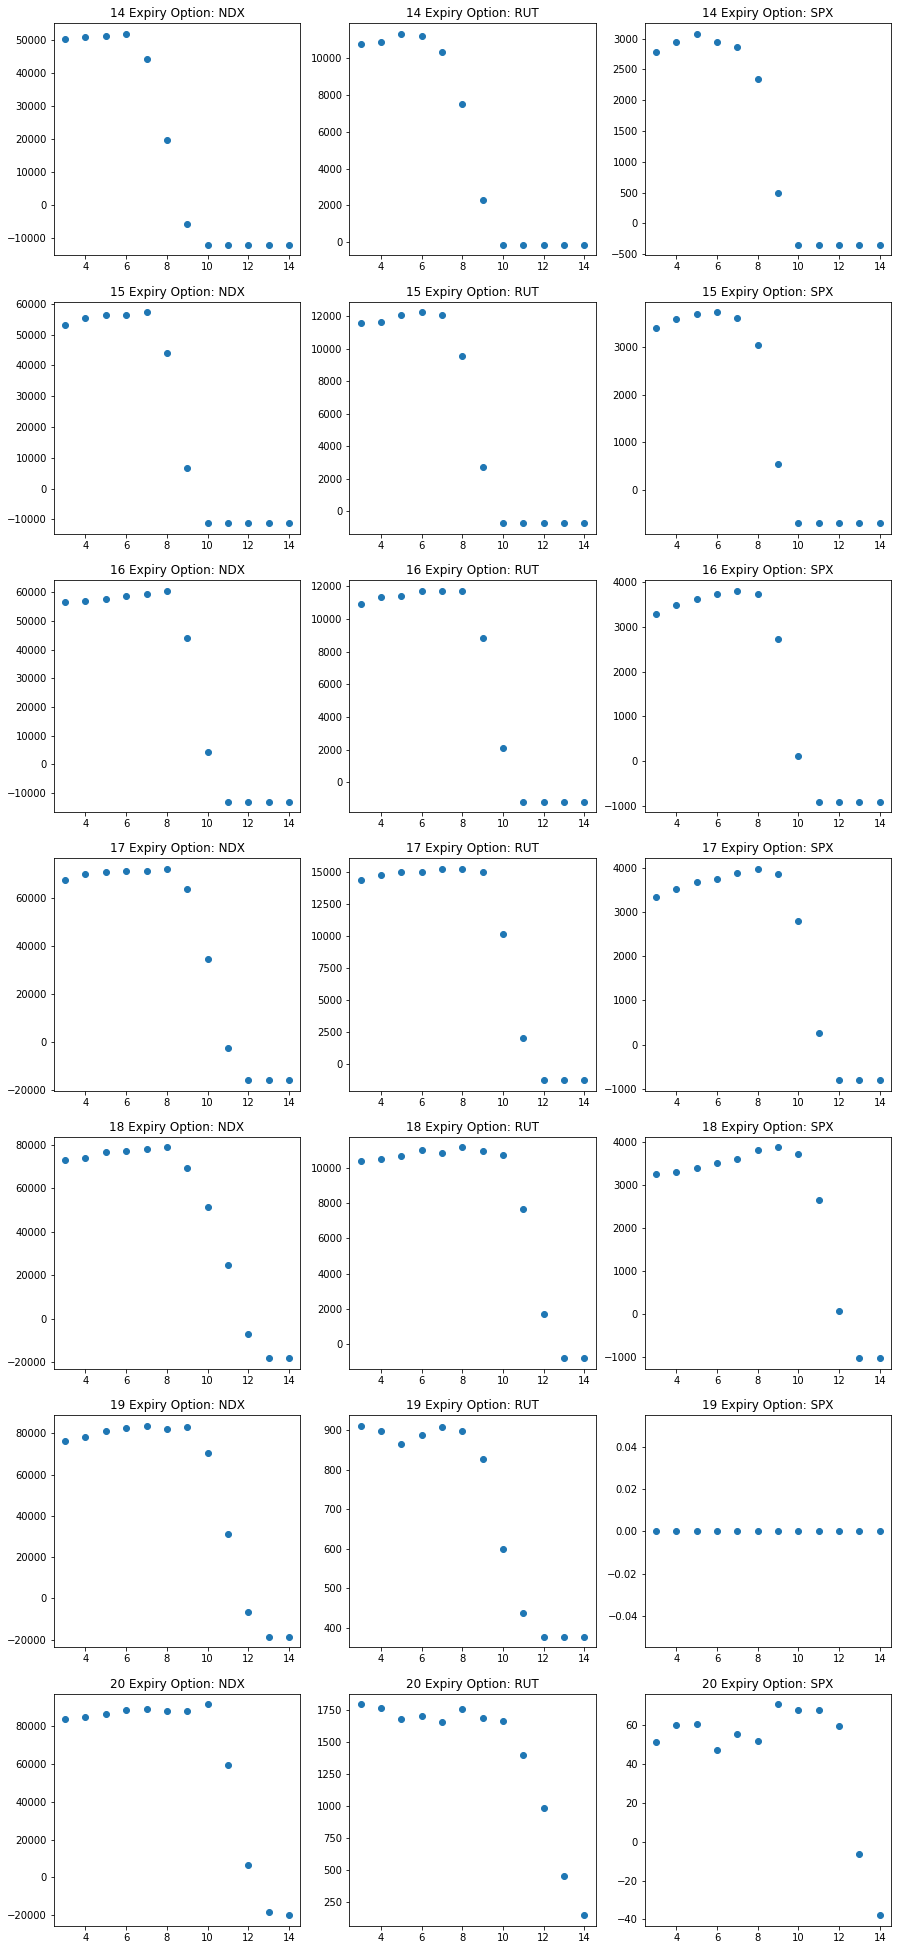

In [12]:
def visualize2(b: dict):
    columns = len(b)
    rows = len(list(b.values())[0])
    scale = 5

    fig, axs = plt.subplots(rows, columns)
    fig.set_figwidth(columns * scale)
    fig.set_figheight(rows * scale)
    i = 0
    for asset, values in b.items():
        j = 0
        for name, state in values.items():
            if type(state) is dict:
                lists = sorted(state.items())
                x, y = zip(*lists)
                axs[j, i].scatter(x, y)
                axs[j, i].set_title(f"{name}: {asset}")
            elif type(state) is list:
                axs[j, i].hlines(1,1,20)  # Draw a horizontal line
                axs[j, i].eventplot(state, orientation='horizontal', colors='b')
                axs[j, i].set_title(f"{name}: {asset}")
            j+=1
        i+=1
    plt.show()

def visualize(b: dict):
    columns = len(b)
    rows = 1 # len(list(b.values())[0])
    scale = 5

    fig, axs = plt.subplots(rows, columns)
    fig.set_figwidth(columns * scale)
    fig.set_figheight(rows * scale)
    i = 0
    for asset, values in b.items():
        j = 0
        #for name, state in values.items():
        if type(values) is dict:
            lists = sorted(values.items())
            x, y = zip(*lists)
            axs[i].scatter(x, y)
            axs[i].set_title(f"{asset}")
        # elif type(values) is list:
        #     axs[j, i].hlines(1,1,20)  # Draw a horizontal line
        #     axs[j, i].eventplot(values, orientation='horizontal', colors='b')
        #     axs[j, i].set_title(f"{asset}")
        i+=1
    plt.show()

def visualize3(b: dict):
    columns = len(b)
    rows = len(list(b.values())[0])
    scale = 5

    fig, axs = plt.subplots(rows, columns)
    fig.set_figwidth(columns * scale)
    fig.set_figheight(rows * scale)
    #i = 0
    for asset, values in b.items():
        i = 0
        for name, state in values.items():
            if type(state) is dict:
                lists = sorted(state.items())
                x, y = zip(*lists)
                axs[i].scatter(x, y)
                axs[i].set_title(f"{name}: {asset}")
            elif type(state) is list:
                axs[i].hlines(1,1,20)  # Draw a horizontal line
                axs[i].eventplot(state, orientation='horizontal', colors='b')
                axs[i].set_title(f"{name}: {asset}")
            i+=1
        #i+=1
    plt.show()


visualize2(results)

Start grouping
Grouping processed in 0.96875 seconds
Start grouping
Grouping processed in 0.46875 seconds
Start grouping
Grouping processed in 0.140625 seconds


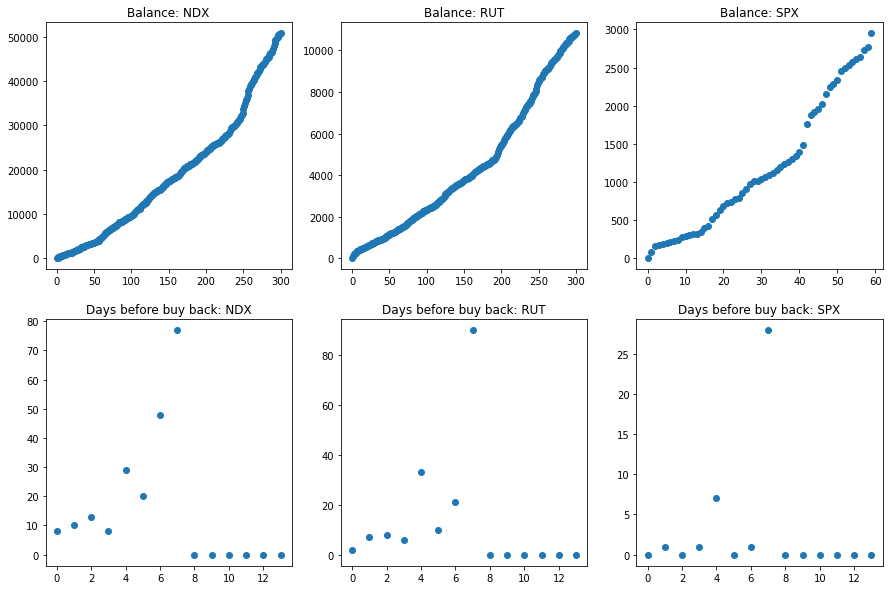

In [14]:
#assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
#assets = ['AMZN']
results = {}
for asset_name in european_assets:
    results[asset_name] = process_buy_back(df_asset[asset_name][0], min_days_to_hold=4)

visualize2(results)